Check equation for smoother step profiles of Kv
================================================================

### Smoothed $\kappa$ profile

What happens if we smooth out the diffusivity profile from a step (Heaviside function) to a smoothed Heaviside function? (The concentration will look smoother but how does it change the tracer transport?)

Smoothed Heaviside function:

$HS(z) = \begin{cases}
\kappa_{bg} &\mbox{if } z<\frac{L}{2}-\epsilon \\
\kappa_{bg}+ \kappa_{can}(0.5 + \frac{z-\epsilon}{2\epsilon} + \frac{1}{2\pi}\sin{\frac{\pi(z-\epsilon)}{\epsilon}}) & \mbox{if } \frac{L}{2}-\epsilon < z < \frac{L}{2}+\epsilon \\
\kappa_{can} & \mbox{if }  \frac{L}{2}+\epsilon < z
 \end{cases} $

We will compare several values of $\epsilon$.

In the canyon, $L/2 = H_{rim}$

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import scipy.interpolate as interp
import seaborn as sns
import struct

/home/kramosmu/anaconda3/lib/python3.5/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
import canyon_tools.readout_tools as rout

### Functions

In [174]:
def smoothHS(nx, xi, epsilon, dx, k1, k2, Z):
    '''Build smooth Heaviside function, of width 2*epsilon centred at index xi
    Check:
    xi < nx.
    In this case, epsilon = smoothness/dx, where smoothness 
    is the 1/2 distance over which the transition from kbg to kcan happens.''' 
    
   
    hs = np.zeros(nx)
    hs[:xi-epsilon+1] = k1
    
    for ii in range(2*epsilon):
        hs[xi+ii-epsilon] = k1+(0.5 + (ii-epsilon)/(2*epsilon) + 
                            (np.sin(np.pi*(ii-epsilon)/epsilon))/(2*np.pi))*k2

    hs[xi+epsilon-1:] = k2+k1
    return hs

def smoothHS_res(nrim, epsilon, dz, k1, k2, Z):

    width = 0
    i_top = nrim
    # Find number of depth levels above rim to make thickness epsilon
    while width < epsilon:
        width = width + dz_vec[i_top]
        i_top = i_top - 1
    
    i_bot = nrim    
    width = 0
    # Find number of depth levels above rim to make thickness epsilon
    while width < epsilon-(dz_vec[i_bot]/2):
        width = width + dz_vec[i_bot]
        i_bot = i_bot + 1
   
    hs = np.zeros(np.shape(RC))
    hs[:i_top+1] = k1
      
    for ii in range(i_top,i_bot):
    
        zz = -(Z[ii]-Z[i_top]) # depth is negative
        hs[ii] = k1 + (0.5 + (zz-epsilon)/(2*epsilon) + (np.sin(np.pi*(zz-epsilon)/epsilon))/(2*np.pi))*k2
        
    hs[i_bot-1:] = k2+k1
    
    return(hs,i_top,i_bot)
  
#------------------------------------------------------------------------------------------------------------------------
def build_3D_diff_rim(hFacC, kv_bg, kv_can, delta, thresh, RC, dz, epsilon):
    
    kv_array = np.ones(np.shape(hFacC))*np.nan # Initial kv array
    ind_canyon = np.argwhere(delta > thresh) # horizontal indices of canyon, (y,x)
    
    ii = 0

    for ind in ind_canyon:
        rim_ind = np.argmin(hFacC[:,ind[0],ind[1]]) # find bottom z-index (first zero in hFacC no canyon)

        if rim_ind == 0: # this means hfac=1 through the whole water col
            rim_ind = 89

        dz_rim = dz[rim_ind]
        
        step = max([int(epsilon/dz_rim),1]) # This step is important to make e=5 cases = to original enhanced diff.
        
        kappa_profile = smoothHS(nz, rim_ind, step, dz_rim, kv_bg, kv_can, RC) 
        
        kv_array[:, ind[0], ind[1]] = kappa_profile
        ii = ii+1

    return kv_array

### Input

In [21]:
## Get grid variables

fileNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run68/gridGlob.nc'
GridOutNoC = Dataset(fileNoC)

fileCan='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
GridOut = Dataset(fileCan)

depth_NoC = rout.getField(fileNoC,'Depth')
depth_Can = rout.getField(fileCan,'Depth')

hFacC = rout.getField(fileNoC,'HFacC') #(90,616,360)
hFacCcan = rout.getField(fileCan,'HFacC') #(90,616,360)
land_mask = rout.getMask(fileCan, 'HFacC') 

Y = GridOut.variables['Y']
X = GridOut.variables['X']
RC = GridOut.variables['RC']

dz_vec = GridOut.variables['drC'][:]

### Heaviside profiles of diffusivity

These will be the profiles I'll use as smooth steps. I need to interpolate them to the rim depth as I did for the "realistic profiles", stretching and squeezing them as needed along and across the canyon.

In [22]:
#Input 
nx = 616
ny = 360
nz = 90
dz = 5 # m at rim

# Space
L = 1200            # total depth (m)

# Diffusivity
kappa_bg = 1E-5              # background diffusivity
kappa_can = 1E-2-(1E-5)

In [199]:
# Examples of profiles using different smoothing length scale epsilon. 
# Min epsilon I can use is 5 m = dz but that just looks like a step

e5 = 1 # 5m/dz
kappa_e5 = smoothHS(nz, 29, e5, dz, kappa_bg, kappa_can, RC) 
# index 26 corresponds to the rim at station DnS, but the rim location changes from place to place in the canyon

e25 = 5 # 15m/dz
kappa_e25 = smoothHS(nz, 29, e25, dz, kappa_bg, kappa_can, RC) 

e50 = 10 # 50m/dz
kappa_e50 = smoothHS(nz, 29, e50, dz, kappa_bg, kappa_can, RC)

e100 = 20 # 100m/dz
kappa_e100 = smoothHS(nz, 29, e100, dz, kappa_bg, kappa_can, RC)

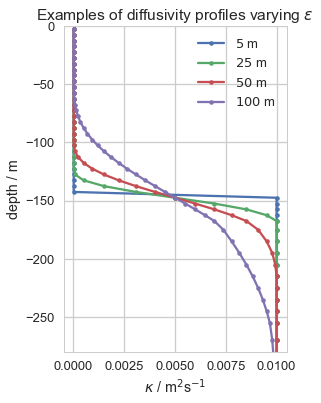

In [200]:
# Plot kv profiles
sns.set_context('talk')
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(4,6))

ax.plot(kappa_e5,RC,'.-', label = '$5$ m')
ax.plot(kappa_e25,RC,'.-', label = '$25$ m')
ax.plot(kappa_e50,RC,'.-', label = '$50$ m')
ax.plot(kappa_e100,RC,'.-', label = '$100$ m')


ax.set_xlabel('$\kappa$ / m$^2$s$^{-1}$')
ax.set_ylabel('depth / m')
ax.set_title('Examples of diffusivity profiles varying $\epsilon$')

ax.set_ylim(-280,0)
ax.legend(loc=0)

In [181]:
nrim = 29 
epsilon = 100
k1 = kappa_bg
k2 = kappa_can

hs, i_top, i_bot = smoothHS_res(nrim, epsilon, dz_vec, k1, k2, RC)

(-400, 0)

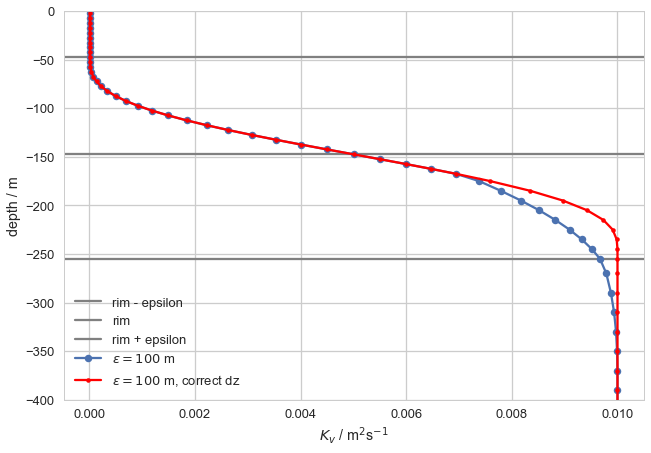

In [191]:
fig, ax = plt.subplots(1,1)
ax.axhline(RC[nrim], color='0.5', label='rim - epsilon')
ax.axhline(RC[i_top], color='0.5', label='rim')
ax.axhline(RC[i_bot], color='0.5', label='rim + epsilon')
ax.plot(kappa_e100,RC,'.-',markersize=15, label = '$\epsilon=100$ m')
ax.plot(hs,RC, 'r.-', label='$\epsilon=100$ m, correct dz')
ax.set_xlabel('$K_v$ / m$^2$s$^{-1}$')
ax.set_ylabel('depth / m')
ax.legend(loc=0)
ax.set_ylim(-400,0)

In [192]:
nrim = 29 
epsilon = 50
k1 = kappa_bg
k2 = kappa_can

hs, i_top, i_bot = smoothHS_res(nrim, epsilon, dz_vec, k1, k2, RC)

(-400, 0)

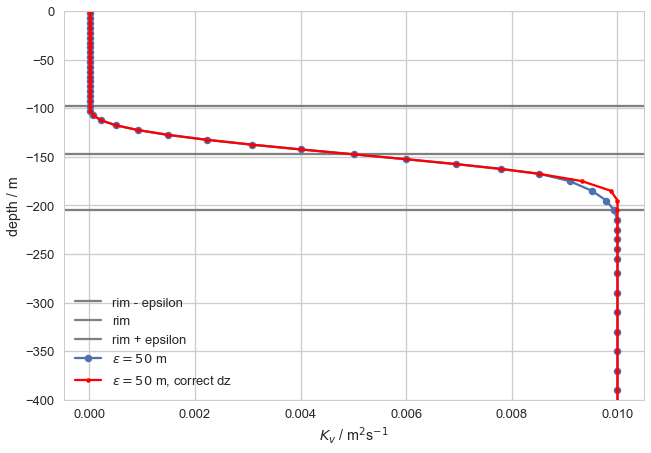

In [193]:
fig, ax = plt.subplots(1,1)
ax.axhline(RC[nrim], color='0.5', label='rim - epsilon')
ax.axhline(RC[i_top], color='0.5', label='rim')
ax.axhline(RC[i_bot], color='0.5', label='rim + epsilon')
ax.plot(kappa_e50,RC,'.-',markersize=15, label = '$\epsilon=50$ m')
ax.plot(hs,RC, 'r.-', label='$\epsilon=50$ m, correct dz')
ax.set_xlabel('$K_v$ / m$^2$s$^{-1}$')
ax.set_ylabel('depth / m')
ax.legend(loc=0)
ax.set_ylim(-400,0)

In [194]:
nrim = 29 
epsilon = 25
k1 = kappa_bg
k2 = kappa_can

hs, i_top, i_bot = smoothHS_res(nrim, epsilon, dz_vec, k1, k2, RC)

(-400, 0)

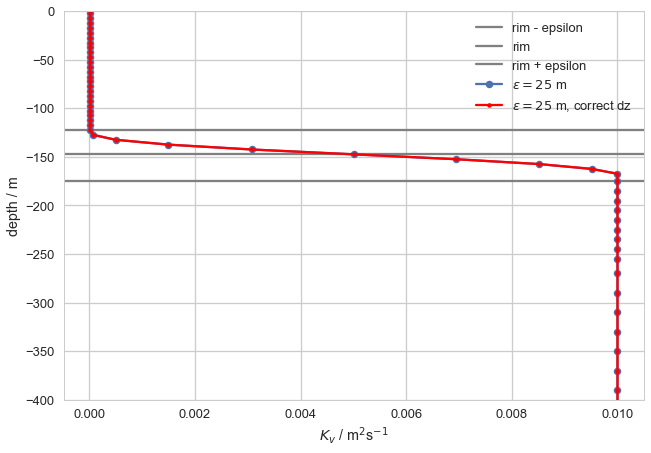

In [201]:
fig, ax = plt.subplots(1,1)
ax.axhline(RC[nrim], color='0.5', label='rim - epsilon')
ax.axhline(RC[i_top], color='0.5', label='rim')
ax.axhline(RC[i_bot], color='0.5', label='rim + epsilon')
ax.plot(kappa_e25,RC,'.-',markersize=15, label = '$\epsilon=25$ m')
ax.plot(hs,RC, 'r.-', label='$\epsilon=25$ m, correct dz')
ax.set_xlabel('$K_v$ / m$^2$s$^{-1}$')
ax.set_ylabel('depth / m')
ax.legend(loc=0)
ax.set_ylim(-400,0)